# Read Dataset

In [6]:
import pandas as pd

# Baca data dari file CSV
df = pd.read_csv('mntl.csv')

# Tampilkan dataframe
print(df.head())

   Unnamed: 0       tag                  patterns  \
0           0  greeting                        Hi   
1           1  greeting                       Hey   
2           2  greeting  Apakah ada orang disana?   
3           3  greeting                      Halo   
4           4  greeting                     Hello   

                                           responses  
0  ['Halo. Ceritakan bagaimana perasaan Anda hari...  
1  ['Halo. Ceritakan bagaimana perasaan Anda hari...  
2  ['Halo. Ceritakan bagaimana perasaan Anda hari...  
3  ['Halo. Ceritakan bagaimana perasaan Anda hari...  
4  ['Halo. Ceritakan bagaimana perasaan Anda hari...  


# Preprocessing

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Convert 'patterns' column to strings
df['patterns'] = df['patterns'].astype(str)

# Tokenisasi dan pad sequences
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(df['patterns'])
vacab_size = len(tokenizer.word_index)

ptrn2seq = tokenizer.texts_to_sequences(df['patterns'])
X = pad_sequences(ptrn2seq, padding='post')

# Label encoding untuk variabel target
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(df['tag'])

# Training Model

In [23]:
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout
import numpy as np

model = Sequential([
          Input(shape=(X.shape[1],)),  # Fix: Added comma in the shape tuple
          # Embedding layer

          Embedding(input_dim=vacab_size + 1, output_dim=100),
          # LSTM layers
          LayerNormalization(),
          LSTM(32, return_sequences=True),
          LayerNormalization(),
          LSTM(32, return_sequences=True),
          LSTM(32),
          LayerNormalization(),

          # Dense layers
          LayerNormalization(),
          Dense(128, activation="relu"),
          Dropout(0.2),

          LayerNormalization(),
          Dense(128, activation="relu"),
          Dropout(0.2),
          Dense(len(np.unique(y)), activation="softmax")
])


model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = model.fit(x=X, y=y, batch_size=10, epochs=50)

Epoch 1/50
32/32 [==============================] - 9s 32ms/step - loss: 4.5985 - accuracy: 0.0193
Epoch 2/50
32/32 [==============================] - 1s 32ms/step - loss: 4.4374 - accuracy: 0.0064
Epoch 3/50
32/32 [==============================] - 1s 33ms/step - loss: 4.3189 - accuracy: 0.0418
Epoch 4/50
32/32 [==============================] - 1s 30ms/step - loss: 4.2042 - accuracy: 0.0418
Epoch 5/50
32/32 [==============================] - 1s 30ms/step - loss: 4.0426 - accuracy: 0.0482
Epoch 6/50
32/32 [==============================] - 1s 38ms/step - loss: 3.8195 - accuracy: 0.0514
Epoch 7/50
32/32 [==============================] - 2s 49ms/step - loss: 3.6864 - accuracy: 0.0772
Epoch 8/50
32/32 [==============================] - 2s 48ms/step - loss: 3.3708 - accuracy: 0.1190
Epoch 9/50
32/32 [==============================] - 1s 32ms/step - loss: 3.0961 - accuracy: 0.1672
Epoch 10/50
32/32 [==============================] - 1s 31ms/step - loss: 2.9065 - accuracy: 0.1736
Epoch 11/

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 23, 100)           36000     
                                                                 
 layer_normalization_25 (La  (None, 23, 100)           200       
 yerNormalization)                                               
                                                                 
 lstm_15 (LSTM)              (None, 23, 32)            17024     
                                                                 
 layer_normalization_26 (La  (None, 23, 32)            64        
 yerNormalization)                                               
                                                                 
 lstm_16 (LSTM)              (None, 23, 32)            8320      
                                                                 
 lstm_17 (LSTM)              (None, 32)               

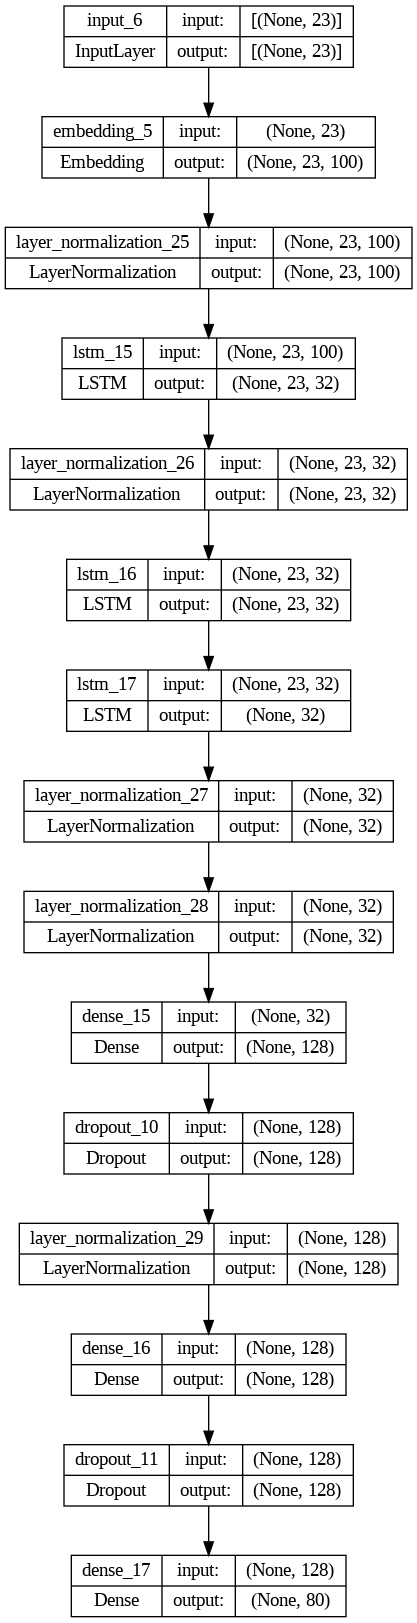

In [25]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## Training Result Visualization

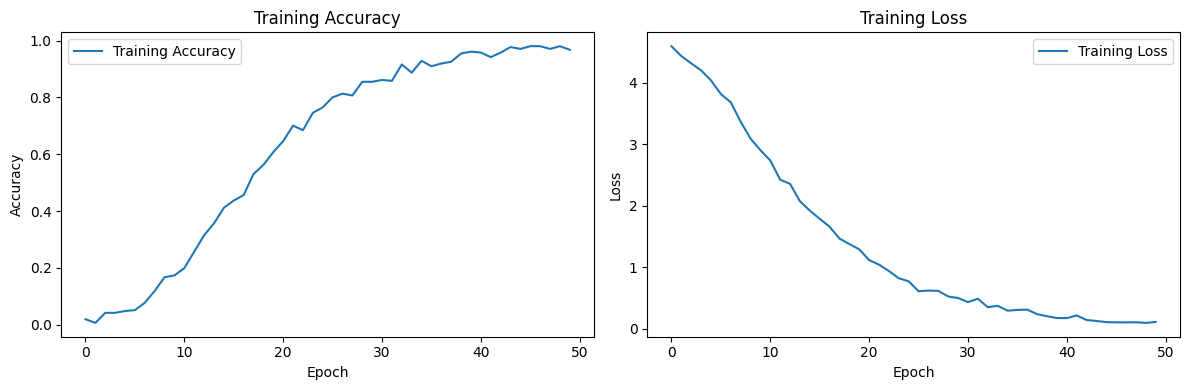

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save Model

In [27]:
model.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
import pickle

with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

with open('maxlen.pkl', 'wb') as maxlen_file:
    pickle.dump(X, maxlen_file)

with open('lbl_enc.pkl', 'wb') as lbl_enc_file:
    pickle.dump(lbl_enc, lbl_enc_file)

# Model Testing

In [29]:
import re
import random

def generate_answer(pattern):
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', pattern)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)

    # Tokenize and pad the input sequence
    x_test = tokenizer.texts_to_sequences(text)
    x_test = pad_sequences(x_test, padding='post', maxlen=X.shape[1])

    # Make predictions
    y_pred = model.predict(x_test)
    predicted_class = np.argmax(y_pred, axis=-1)
    tag = lbl_enc.inverse_transform(predicted_class)[0]

    # Get responses associated with the selected tag
    responses = df[df['tag'] == tag]['responses'].values

    if len(responses) > 0:
        # If there are responses, choose a random one
        response = random.choice(responses)
        if isinstance(response, np.ndarray):
            # Convert numpy array to string
            response = response[0]
    else:
        # If no responses are found, provide a default message
        response = "Maafkan saya, saya tidak mengerti hal itu."

    print("you: {}".format(pattern))
    print("model: {}".format(response))

generate_answer('Hai! Apa Kabar?')

1/1 [==============================] - 2s 2s/step
you: Hai! Apa Kabar?
model: ['Halo. Ceritakan bagaimana perasaan Anda hari ini?', 'Hai. Apa yang membawamu kemari hari ini?', 'Hai. Bagaimana perasaan Anda hari ini?', 'Senang bertemu dengan Anda. Bagaimana perasaan Anda saat ini?', 'Halo. Senang melihat Anda kembali. Apa yang sedang terjadi di duniamu saat ini?']


In [30]:
generate_answer('Kamu siapa')

1/1 [==============================] - 0s 59ms/step
you: Kamu siapa
model: ['Saya Kenari, Asisten AI Terapi Pribadi Anda. Bagaimana perasaan Anda hari ini', 'Saya Kenari, AI Terapi Asisten yang dirancang untuk membantu Anda. Ceritakan tentang diri Anda.', 'Saya Kenari. Saya adalah agen percakapan yang dirancang untuk meniru terapis. Jadi, bagaimana perasaan Anda hari ini?', 'Anda bisa memanggil saya Kenari.', 'Saya Kenari!', 'Panggil saya Kenari']


In [31]:
generate_answer('Siapa yang menciptakanmu?')

1/1 [==============================] - 0s 45ms/step
you: Siapa yang menciptakanmu?
model: ['Saya diciptakan oleh Tim CH2-PS130 Capstone Project Program Bangkit Academy 2023 Batch 2.', 'Saya dilatih menggunakan dataset teks dengan teknik Deep Learning & Natural Language Processing.', 'Saya diciptakan oleh Tim CH2-PS130 Capstone Project Program Bangkit Academy 2023 Batch 2. Saya dilatih menggunakan dataset teks dengan teknik Deep Learning & Natural Language Processing.']


In [32]:
generate_answer('Saya pikir saya depresi.')

1/1 [==============================] - 0s 56ms/step
you: Saya pikir saya depresi.
model: ['Bicarakan tentang apa yang sedang terjadi. Anda akan baik-baik saja.', 'Bicaralah padaku. Ceritakan lebih banyak. Membuka diri kepada orang lain bisa membantu.', 'Terkadang ketika kita depresi, sulit untuk peduli tentang apapun. Sulit untuk melakukan hal-hal yang paling sederhana. Beri diri Anda waktu untuk sembuh.']
